In [1]:
import torch
import pathlib
import numpy as np
import pandas as pd
import torch.nn as nn
import json
import sys
import pickle
import csv
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    dot_product = torch.matmul(embeddings, embeddings.t())

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diag(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = square_norm.unsqueeze(0) - 2.0 * dot_product + square_norm.unsqueeze(1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances[distances < 0] = 0

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = distances.eq(0).float()
        distances = distances + mask * 1e-16

        distances = (1.0 -mask) * torch.sqrt(distances)

    return distances

In [3]:
with open('per_prot_emb_full.p', 'rb') as fp:
    data = pickle.load(fp)
print(len(data.keys()))

10440


In [4]:
data_key = list(data.keys())
print(type(data_key[1]))

<class 'str'>


In [119]:
with open('emb_list.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(data_key)

In [5]:
vector_list = []
for i in range(len(data_key)):
    vector_list.append(data[data_key[i]])
print(type(vector_list[1]))
print(len(vector_list))

<class 'numpy.ndarray'>
10440


In [6]:
# convert list into ndarray

vector_np = np.asarray(vector_list, dtype=np.float32)

In [122]:
# convert the ndarray to Torch tensor
vector_tensor = torch.from_numpy(vector_np)
print(type(vector_tensor))
print(vector_tensor.size())

<class 'torch.Tensor'>
torch.Size([10440, 1024])


In [36]:
pair_dist = _pairwise_distances(vector_tensor, squared=True)
print(type(pair_dist))
print(pair_dist.size())

<class 'torch.Tensor'>
torch.Size([10440, 10440])


In [38]:
# store the correlation matrix to avoid repeat computation 

torch.save(pair_dist, 'protein_pairwise_distance.pt')

In [42]:
pair_dist

tensor([[ 0.0000, 15.2439, 14.8064,  ..., 37.3347, 31.9050, 14.9117],
        [15.2439,  0.0000, 12.0236,  ..., 26.5548, 24.1060, 12.0251],
        [14.8064, 12.0236,  0.0000,  ..., 33.0954, 30.1227, 15.4502],
        ...,
        [37.3347, 26.5548, 33.0954,  ...,  0.0000, 34.5437, 33.4978],
        [31.9050, 24.1060, 30.1227,  ..., 34.5437,  0.0000, 27.5117],
        [14.9117, 12.0251, 15.4502,  ..., 33.4978, 27.5117,  0.0000]])

In [56]:
# get the 25 most distant proteins

most_dist = np.partition(pair_dist, -25)
most_dist[:,-25:]

array([[ 73.72389 ,  78.8778  ,  79.38347 , ..., 163.319   , 109.56392 ,
         96.59042 ],
       [ 64.439735,  66.068634,  66.33541 , ...,  76.14493 , 109.61124 ,
         87.235245],
       [ 70.100395,  71.11914 ,  73.67447 , ...,  91.74823 ,  77.117935,
         75.582886],
       ...,
       [ 85.34863 ,  90.880295,  90.90056 , ..., 113.81573 , 166.28444 ,
        110.63531 ],
       [ 71.003174,  74.04628 ,  80.00438 , ..., 174.16066 , 118.15656 ,
        121.462364],
       [ 61.514168,  61.943665,  76.02295 , ...,  83.62598 ,  83.16367 ,
         82.55963 ]], dtype=float32)

In [58]:
# get indices of the most distant proteins

most_dist_loc = np.argpartition(pair_dist, -25)
most_dist_loc[:,-25:]

tensor([[5593, 4907,  676,  ..., 5623, 5241, 5773],
        [5593,  676,  267,  ...,  390, 6118, 5241],
        [5373, 5593, 1333,  ..., 9399,  676, 4907],
        ...,
        [7267, 5670,  267,  ..., 9399, 5623, 3797],
        [5670, 1088,  626,  ..., 5623, 7943, 6118],
        [6810, 1333, 3797,  ..., 7943, 5670, 1088]])

In [7]:
# create distance matrix for training set positives

train_path = pathlib.Path.home().joinpath('Documents\ms_thesis_ppi\dataset', 'test', 'test_positive.csv')
df = pd.read_csv(train_path)
int_A = list(df['int_A'])
int_B = list(df['int_B'])
all_pos = int_A + int_B

train_v = []
for i in range(len(all_pos)):
    train_v.append(data[all_pos[i]])
# create tensors from list
vector_tensor = torch.from_numpy(np.asarray(train_v, dtype=np.float32))
print(vector_tensor.size())

torch.Size([222, 1024])


In [8]:
pos_pair_dist = _pairwise_distances(vector_tensor, squared=True)
print(type(pos_pair_dist))
print(pos_pair_dist.size())

<class 'torch.Tensor'>
torch.Size([222, 222])


In [9]:
# get 15 closest proteins
# np.argpartition(A, k)
close_dist = np.partition(pos_pair_dist[3], 2)[1:2]
print(close_dist[0])
close_prot = np.argpartition(pos_pair_dist[3], 2)[1:2]
print(close_prot.numpy()[0])
print(pos_pair_dist[3, 14].numpy())

6.3740788
39
17.321507


In [10]:
pos_pair_dist = np.asarray(pos_pair_dist, dtype=np.float32)

# np.savetxt("test_pos_pair_dist.csv", pos_pair_dist, delimiter=",")

In [11]:
# plot heatmap

h_df = pd.read_csv("pos_pair_dist.csv", header=None)
df_r = h_df.iloc[:15, :15]

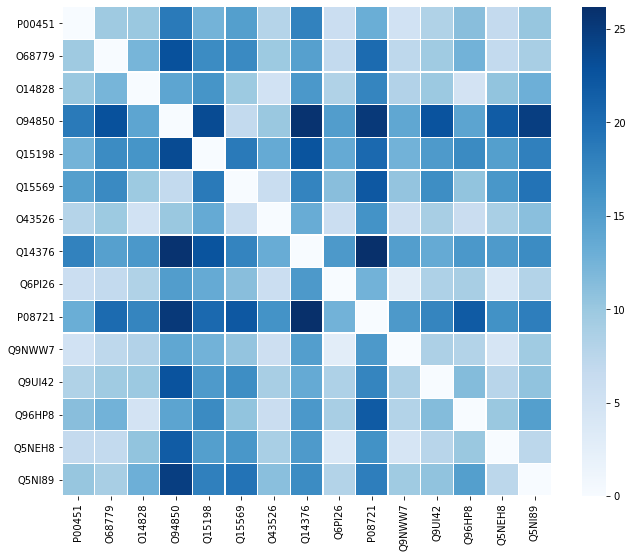

In [25]:
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(df_r, xticklabels=all_pos[:15], yticklabels=all_pos[:15], cmap="Blues", square=True, linewidth=0.3)
fig.savefig("distance_heatmap.png")
plt.show()

In [12]:
with open('pos_pair_dist.csv', newline='') as f:
    reader = csv.reader(f)
    pos_dist = list(reader)

print(len(pos_dist))

3982


In [13]:
# get histogram data
pos_pair_hist = np.histogram(pos_pair_dist, bins=25)
#sb.histplot(data=pos_pair_hist, binwidth=3)

In [14]:
freq = pos_pair_hist[0]
bins = pos_pair_hist[1]
print(len(bins))
print(len(freq))
#print(x[0])
freq[0] = freq[0] - len(all_pos)
print(freq[0])

26
25
312


[  312  4692 10506 11156  8678  4778  2828  2054  1458  1032   644   438
   250    80    86    20    24    12     6     6     0     0     0     0
     2]


C:\Users\kmmbd\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


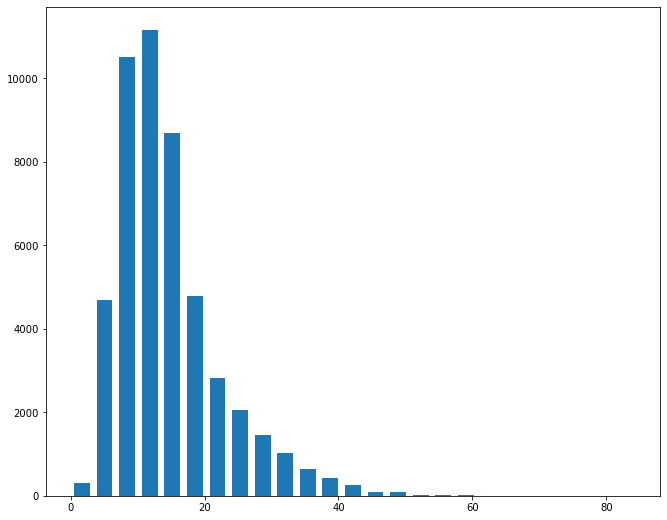

In [15]:
center = (bins[:-1] + bins[1:]) / 2
#sb.set_theme(style="whitegrid")
print(freq)
width = 0.7 * (bins[1] - bins[0])
fig, ax = plt.subplots(figsize=(11, 9))
plt.bar(center, freq, align='center', width=width)
ax.set_xlabel = "eucledian distance"
ax.set_ylabel = "protein count"
fig.savefig("distance_barplot.png")
fig.show()

<h1>Create triplets and check if possible positives exist in whole dataset</h1>

In [114]:
in_file_2 = pathlib.Path.home().joinpath('Documents\ms_thesis_ppi','dataset','9606_Q1.txt')
df_whole = pd.read_csv(in_file_2, sep="\t", header=0, dtype='unicode')
df_whole = df_whole[['UniprotID_A', 'UniprotID_B']] # only keep specific columns
df_whole.columns = ["int_A", "int_B"]
df_whole

,int_A,int_B
0,A0A024R0Y4,Q8WWY3
1,A0A024R4Q5,Q96D03
2,A0A024R4Q5,P51911
3,A0A024R5S0,Q9NVV9
4,A0A024R5S0,Q02446
...,...,...
83944,Q81QS8,Q9Y6X8
83945,A0A0F7RKT3,Q9Y6X8
83946,Q81U00,Q9Y6X8
83947,Q81QN9,Q9Y6X8


In [115]:
whole_int_A = df_whole['int_A'].tolist()
whole_int_B = df_whole['int_B'].tolist()
print(len(whole_int_A),len(whole_int_B))

83949 83949


In [172]:
interaction_dict = {}

for prot in all_pos:
    partner_list = []
    for i in range(len(whole_int_A)):
        if whole_int_A[i]==prot:
            partner_list.append(whole_int_B[i])
        elif whole_int_B[i]==prot:
            partner_list.append(whole_int_A[i])
        else:
            continue
    # add the list of partners to the dict with the prot name as key
    interaction_dict[prot] = partner_list
        

In [173]:
# save the dictionary

with open('test_pos_partners.json', 'w') as fp:
    json.dump(interaction_dict, fp)

In [174]:
def comparator(protA, protB, protC, protD, dA, dB, protein_partners):
    partner_list_A = protein_partners[protA]
    partner_list_B = protein_partners[protB]
    if dA < dB:
        anchor = protA
        positive = protB
        if (protC not in partner_list_A):
            negative = protC
        else:
            if (protC not in partner_list_B):
                anchor = protB
                positive = protA
                negative = protC
            else:
                negative = 'NaN'
    else:
        anchor = protB
        positive = protA
        if (protD not in partner_list_B):
            negative = protD
        else:
            if (protC not in partner_list_A):
                anchor = protA
                positive = protB
                negative = protC
            else:
                negative = 'NaN'
    triplet = []
    triplet.append(anchor)
    triplet.append(positive)
    triplet.append(negative)
    return triplet

In [175]:
triplet_dict = {}

for i in range(len(int_A)):
    length = len(int_A)
    protA = int_A[i]
    protB = int_B[i]
    closest_prot_A = np.argpartition(pos_pair_dist[i], 2)[1:2]
    protC = all_pos[closest_prot_A[0]]
    closest_prot_B = np.argpartition(pos_pair_dist[i+length], 2)[1:2]
    protD = all_pos[closest_prot_B[0]]
    dA = np.partition(pos_pair_dist[i], 2)[1:2]
    dB = np.partition(pos_pair_dist[i+length], 2)[1:2]
    triplets = comparator(protA, protB, protC, protD, dA, dB, interaction_dict)
    # triplet_dict.setdefault(i, [])
    if triplets[2] != 'NaN':
        triplet_dict[i] = triplets

In [176]:
# save to json

with open('test_triplets.json', 'w') as fp:
    json.dump(triplet_dict, fp)

In [177]:
# check

triplet_dict[0][2]

'Q8TF72'

In [167]:
t = {}
string = ['test', 'again']
t[0] = string
print(t[0][0])

test
